In [1]:
'''Import'''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import time 
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

#ML
from sklearn.gaussian_process import GaussianProcessRegressor 

In [2]:
def blackbox_clmND(slatop, leaflong, frootleaf, slopebeta, fff, baseflow, fmax):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    pft = 12 #arctic grass  
    
    #PFT Params
    change_pft_param('slatop', pft, slatop, target_param_file)
    change_pft_param('leaf_long', pft, leaflong, target_param_file)
    change_pft_param('froot_leaf', pft, frootleaf, target_param_file)
    
    #NON PFT Params
    change_param('slopebeta', slopebeta, target_param_file)
    change_param('fff', fff, target_param_file)    
    
    os.chdir(CASE_DIR)
    
    #Namelist Params
    change_nl_param('soil_fmax', fmax)
    change_nl_param('baseflow_scalar', baseflow)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2017-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2017-01-01-00000.nc')
    #mean_wtd = -np.mean(dat.ZWT.values) For WTE comparison
    stream_mod = dat.QRUNOFF.values

    #Calculate correlation
    R = rsquared(stream, stream_mod)
    
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2017-01-01-00000.nc')
    
    #return average annual WTE
    #return mean_wtd

    #return R2
    return R

In [3]:
'''Load Optimizer'''
clm_optimizer = BayesianOptimization(
    f = blackbox_clmND,
    pbounds = {'slatop': (0.004, 0.04), 
                'leaflong':(0.32, 2.0),
                'frootleaf':(0.015, 2.0),
                'slopebeta': (-1000, 10),
                'fff': (0.1, 5),
                'baseflow': (0, 10),
                'fmax' : (0.1, 0.7)},
    random_state = 7,
)

#logger object records optimization search
load_logs(clm_optimizer, logs=["./logs/clm_logs_stream.json"]);

In [4]:
print("New optimizer is now aware of {} points.".format(len(clm_optimizer.space)))

New optimizer is now aware of 111 points.


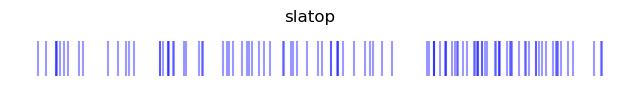

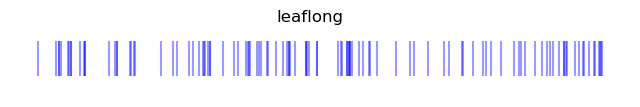

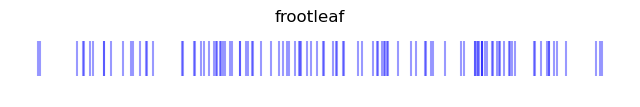

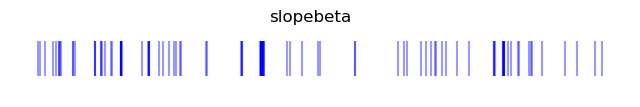

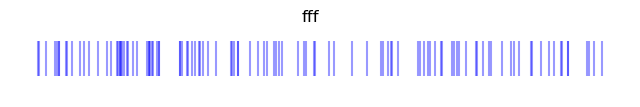

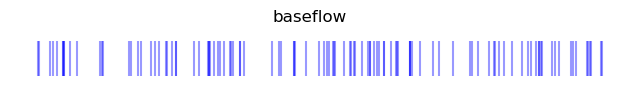

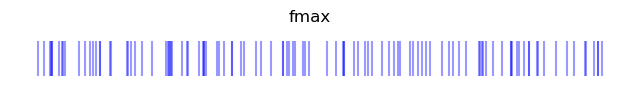

In [5]:
for p in ['slatop', 'leaflong', 'frootleaf', 'slopebeta', 'fff', 'baseflow', 'fmax']:
    x = [res["params"][p] for res in clm_optimizer.res]
    
    fig, ax = plt.subplots(1, 1, figsize = (8,1))
    plt.eventplot(x, orientation='horizontal', colors='b', alpha = 0.4)
    plt.axis('off')
    plt.suptitle(p)

Text(0, 0.5, '$R^2')

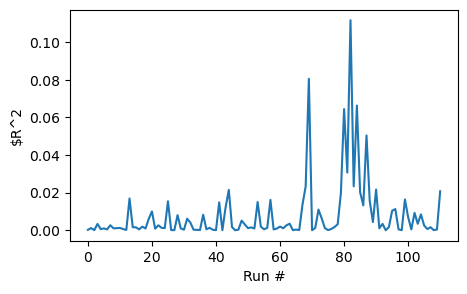

In [6]:
#R2 values - model fit
x = [res["target"] for res in clm_optimizer.res]

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(x)
ax.set_xlabel('Run #')
ax.set_ylabel(r'$R^2')

In [21]:
clm_optimizer.res[82]

{'target': 0.11174684896147047,
 'params': {'baseflow': 0.5072545353770841,
  'fff': 0.30576765176464044,
  'fmax': 0.6841297549136836,
  'frootleaf': 1.7962177509381205,
  'leaflong': 1.8838823827236761,
  'slatop': 0.015687258176423177,
  'slopebeta': -840.6797313887839}}

Open and assign parameter values to final param file

In [43]:
params = xr.open_mfdataset('/glade/u/home/marielj/clm_frost/cesm_cases/clm5_params_bayesopt_stream_final.c171117.nc')
params

<xarray.Dataset>
Dimensions:                     (pft: 79, allpfts: 1, segment: 4, variants: 2)
Coordinates:
    pftname                     (pft) |S40 dask.array<chunksize=(79,), meta=np.ndarray>
  * segment                     (segment) |S40 b'sunlit                      ...
Dimensions without coordinates: pft, allpfts, variants
Data variables: (12/265)
    FUN_fracfixers              (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    a_fix                       (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    aereoxid                    float64 ...
    akc_active                  (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    akn_active                  (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    aleaff                      (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    ...                          ...
    xl                          (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    z0mr                        (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    ztopmx                      (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    rootprof_beta               (variants, pft) float64 dask.array<chunksize=(2, 79), meta=np.ndarray>
    medlynslope                 (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
    medlynintercept             (pft) float64 dask.array<chunksize=(79,), meta=np.ndarray>
Attributes:
    history:                    Fri Nov 17 13:10:57 MST 2017 : Update a few p...
    Conventions:                CF-1.0
    title:                      Vegetation (Plant Function Type or PFT) const...
    NCO:                        4.6.9
    nco_openmp_thread_number:   1
    phs_date:                   Mon Jun 27 15:59:30 MDT 2016
    phs_case_id:                Current hydraulic stress parameter values (se...
    phs_source:                 /glade/p/cgd/tss/people/oleson/modify_param/c...
    phs_title:                  PFT parameter file for Plant Hydraulic Stress...
    history_of_appended_files:  Fri Nov 17 13:10:57 2017: Appended file /glad...

In [44]:
#Set values
params.fff.values = 0.30576765176464044
params.slopebeta.values = -840.6797313887839
params.slatop.values[12] = 0.015687258176423177
params.leaf_long.values[12] = 1.8838823827236761
params.froot_leaf.values[12] = 1.7962177509381205

In [47]:
params.to_netcdf('../cesm_cases/clm5_params_bayesopt_stream.c171117.nc')

/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/dask/array/core.py:1701: RuntimeWarning: invalid value encountered in cast
  x = x.astype(dtype)
/glade/work/marielj/c